# Notebook Description

- Use XGBoost multi-label classifier to further select fitting genes
- Store results in a final dataframe with information about which cancer each gene is important for

# Import, Set working directory 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time
import xgboost as xgb
import shap
import pickle

from xgboost import XGBClassifier

from scipy import stats
from scipy.stats import randint

from imblearn.over_sampling import SMOTE
from boruta import BorutaPy

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.svm import SVR


from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 

%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
def main():
    print("Current Working Directory " , os.getcwd())
    if os.path.exists("C:/Users/micha.DESKTOP-8HA2IGV/OneDrive/Programming/Propulsion Project/intelligencia_backup/intelligencia") :
        # Change the current working Directory    
        os.chdir("C:/Users/micha.DESKTOP-8HA2IGV/OneDrive/Programming/Propulsion Project/intelligencia_backup/intelligencia")
        print("New Working Directory " , os.getcwd())
    else:
        print("Can't change the Current Working Directory")    
        print("Current Working Directory " , os.getcwd())
if __name__ == '__main__':
    main()

Current Working Directory  C:\Users\micha.DESKTOP-8HA2IGV\OneDrive\Programming\Propulsion Project\intelligencia_backup\intelligencia
New Working Directory  C:\Users\micha.DESKTOP-8HA2IGV\OneDrive\Programming\Propulsion Project\intelligencia_backup\intelligencia


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# Classes

## Data Preparation Class
- Read Data - !Drop Unnamed was commented!
- X_and_y: Standard Deviation Filter - !For this document the filter was commented! We do not want to loose any columns
- Split Function
- Smote Upsampling


In [3]:
class DataPrep:
    def __init__(self, seed):
        self.seed = seed
        
  # Read Data
    def read_data(self, path, nrows, usecols):
        data = pd.read_csv(path, nrows=nrows, usecols=usecols)
        data.index = data.iloc[:,0]
        #data.drop(columns = "Unnamed: 0", inplace = True)
        data.columns = [(re.sub('\.\d+', '', gene)) for gene in data.columns]
        return data
  
  # Filter with Standard Deviation Threshold
    def X_and_y(self, data, threshold):
        X = data.drop(columns = 'label')
        #X_sd = X.loc[:, X.std() >= threshold]
        y = data[["label"]]
        return X, y
  
  # Train Test Split data
    def split(self, X, y, test_size):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=self.seed)
        return X_train, X_test, y_train, y_test
  
  # Upsample unbalanced data
    def smote_up(self, X_train, y_train):
        #print("Before OverSampling, counts of label '1': {}".format(sum(y_train['label']==1)))
        #print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train['label']==0)))

        sm = SMOTE(random_state=self.seed)
        X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

        #print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
        #print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

        #print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
        #print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote==0)))
        column_names = X_train.columns

        # Make dataframe again
        X_train_smote = pd.DataFrame(X_train_smote, columns=column_names)
        y_train_smote = pd.DataFrame(y_train_smote, columns=['label'])

        return X_train_smote, y_train_smote
    
    def bulbasaur(self, path, threshold = 0, nrows = None, usecols = None):
        data = self.read_data(path, nrows, usecols)
        X, y = self.X_and_y(data, threshold)
        X_train, X_test, y_train, y_test = self.split(X, y, 0.05)
        X_train_smote, y_train_smote = self.smote_up(X_train, y_train)
        return X_train_smote, y_train_smote, X_test, y_test
    
dataprep = DataPrep(1888)

## Class: FinalDataFrame (fdf)
Retrieve top genes for each cancer by using a hyperparameter-tuned multi-label XGBoost classifier. 

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

class FinalDataFrame:
    def __init__(self, seed, top_genes_path):
        self.seed = seed
        self.top_genes_path = top_genes_path
        self.top_genes = pd.read_csv(top_genes_path)["top_genes"].tolist()
        self.top_genes.append("label")
        
    def load_data(self, chunk_path):
        """
        Load data
        """
        X_train, y_train, X_test, y_test = dataprep.bulbasaur(chunk_path, usecols = self.top_genes)
        return X_train, y_train, X_test, y_test
    
    def run_store_model(self, X_train, y_train, X_test, y_test, filename = 'Output/Models/all_cancers_model.sav'):
        """
        Use best params from hypertuning to fit model
        Then store model as a pickle file
        """
        model = XGBClassifier(colsample_bytree = 0.5,
                              gamma = 0.5,
                              learning_rate = 0.1,
                              max_depth = 5,
                              num_class = 12, 
                              n_estimators = 300, 
                              objective = "multi:softmax",
                              subsample = 0.9,
                              min_child_weight = 1)
        model.fit(X_train, y_train)
        pickle.dump(model, open(filename, 'wb')) 
        
    def load_model(self, filename):
        # load the model from disk
        loaded_model = pickle.load(open(filename, 'rb'))
        
        return loaded_model
    
    def get_genes_df(self, X_train, loaded_model, top_genes_n):
        """
        Get top_genes dataframe with corresponding SHAP values for all cancers
        """
        explainer = shap.TreeExplainer(loaded_model)
        X_importance = X_train
        shap_values = explainer.shap_values(X_test,approximate=False)
        importance_all = pd.DataFrame()
        for i, cancer in enumerate(loaded_model.classes_):
            #print(i, cancer)

            shap_sum = np.abs(shap_values[i]).mean(axis=0)
            importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
            importance_df.columns = ['Gene', 'Shap_Importance']
            importance_df = importance_df.sort_values('Shap_Importance', ascending=False).head(top_genes_n)
            
            #importance_df.index.name = cancer
            importance_df["Cancer"] = cancer
            importance_all = importance_all.append(importance_df)
            
        return importance_all

    def add_combination(self, df):
        """
        Add a column which gives the combination of cancers for duplicated genes
        """
        df_final = pd.DataFrame()
        for gene in df["Gene"].unique():
            df1 = df[df["Gene"] == gene].copy()
            df1["Combination"] = df1["Cancer"].str.cat(sep = ", ")
            df1["SHAP_Combination"] = df1["Shap_Importance"].astype("str").str.cat(sep = ", ")
            df_final = df_final.append(df1)
            
        return df_final
    
    def squirtle(self, chunk_path, pickle, top_genes_n = 20):
        """
        Combine all functions above
        Input: Chunk_path
        Output: Dataframe with shap importance and combinations
        """
        self.X_train, self.y_train, self.X_test, self.y_test = self.load_data(chunk_path)
        loaded_model = self.load_model(pickle)
        df = self.get_genes_df(self.X_train, loaded_model, top_genes_n)
        df_final = self.add_combination(df)
        
        return df_final

    
                  
fdf = FinalDataFrame(1888, top_genes_path = "Output/Results/Top_genes/top_genes_1.0.csv")

# Create df_final

In [10]:
chunk_path = "Output/Chunk_AllCancers.csv"
X_train, y_train, X_test, y_test = fdf.load_data(chunk_path)
#fdf.run_store_model(X_train, y_train, X_test, y_test)

In [18]:
chunk_path = "Output/Chunk_AllCancers.csv"
filename = "Output/Models/all_cancers_model.sav"
df_final = fdf.squirtle(chunk_path, filename, top_genes_n = 50)

In [12]:
loaded_model = pickle.load(open(filename, 'rb'))

In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 400 to 237
Data columns (total 5 columns):
Gene                1200 non-null object
Shap_Importance     1200 non-null object
Cancer              1200 non-null object
Combination         1200 non-null object
SHAP_Combination    1200 non-null object
dtypes: object(5)
memory usage: 56.2+ KB


In [19]:
df_final.to_csv("Output/Results/Final_genes/final_genes_50.csv")

In [17]:
top_genes = pd.read_csv("Output/Results/Final_genes/final_top_genes.csv")

# Combine results with top_genes dataframe 

In [64]:
df_final = pd.read_csv("Output/Results/Final_genes/final_genes_50.csv", index_col = "Unnamed: 0")

In [65]:
all_final = df_final.merge(top_genes, left_on = "Gene", right_on = "Top Gene")
all_final.drop(columns = "Top Gene", inplace = True)

In [32]:
all_final.to_csv("Output/Results/Final_genes/all_final_100.csv")

In [88]:
all_final = pd.read_csv("Output/Results/Final_genes/all_final_50.csv")

# Extract Gene Expression Data

In [89]:
expression = pd.read_csv("Output/Chunk_AllCancers.csv", usecols = all_final.Gene_x.tolist() + ["label", "Unnamed: 0"])
expression.rename(columns = {"Unnamed: 0":"sample"}, inplace = True)

In [90]:
all_final_gene = all_final[["Gene_x", "Gene_y"]]

In [91]:
ensgs = expression.columns[2:]

In [92]:
expression_T = expression.T.reset_index()

In [93]:
expression_T.columns = expression_T.iloc[1]
expression_T.drop([0,1], inplace = True)

In [94]:
expression_symbol = expression_T.merge(all_final_gene, how = "outer", left_on = "label", right_on = "Gene_x").T
expression_symbol.columns = expression_symbol.loc["Gene_y"]

In [95]:
# Drop unnecessary rows
expression_symbol.drop(["Gene_x", "Gene_y", "label"], axis = 0, inplace = True)

# Delete duplicate columns
expression_symbol = expression_symbol.loc[:,~expression_symbol.columns.duplicated()]

In [96]:
expression_symbol.to_csv("Output/Results/Final_genes/expression_data_all_final_symbol_50.csv")

In [85]:
expression_symbol = expression_symbol.loc[:,~expression_symbol.columns.duplicated()]

In [98]:
expression_symbol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4781 entries, 1_breast to 0_thyroid
Columns: 289 entries, MOGAT2 to MTRNR2L12
dtypes: object(289)
memory usage: 10.6+ MB


# Create Selected Chunks

In [142]:
for cancer in expression["label"].unique().tolist():
    expression_cancer = expression[expression["label"] == cancer].T.reset_index().drop([0,1])
    expression_cancer.to_csv("Output/Results/Final_genes/Selected_Chunks/Selected_Chunk_{}.csv".format(cancer))

# Hyperparameter Tuning

## Tuning for 1 

In [8]:
from xgboost import XGBClassifier
xgb = XGBClassifier(num_class = 12)

cv_params = {'max_depth': [7, 11], 
             'min_child_weight': [1], 
             'n_estimators': [500, 1500], 
             'learning_rate': [0.1, 0.05], 
             'subsample': [0.6, 0.8], 
             'colsample_bytree': [0.3, 0.5], 
             'gamma': [0.1, 0.01],
             'seed':[1888],
             'objective': ['multi:softmax']}

optimized_GBM = GridSearchCV(xgb, 
                             cv_params, 
                             scoring = 'accuracy', 
                             cv = 3, 
                             n_jobs = -1,
                             verbose = 2) 

optimized_GBM.fit(X_train, y_train)

print(optimized_GBM.best_score_)
print(optimized_GBM.best_params_)

results = pd.DataFrame({"Best Score": optimized_GBM.best_score_, "Best Params": (optimized_GBM.best_params_)})
results.to_csv("Tune_XGBoost_1.csv")

# Optimize for accuracy since that is the metric used in the Adult Data Set notation

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 89.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 271.6min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 311.9min finished


0.9957516339869281
{'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'multi:softmax', 'seed': 1888, 'subsample': 0.8}


## Tuning for all labels

In [8]:
from xgboost import XGBClassifier
xgb = XGBClassifier(num_class = 12)

cv_params = {'max_depth': [5, 11], 
             'min_child_weight': [1], 
             'n_estimators': [800, 300], 
             'learning_rate': [0.1, 0.01, 0.2], 
             'subsample': [0.7, 0.9], 
             'colsample_bytree': [0.5, 0.8], 
             'gamma': [0.1, 0.5],
             'seed':[1888],
             'objective': ['multi:softmax']}

optimized_GBM = GridSearchCV(xgb, 
                             cv_params, 
                             scoring = 'accuracy', 
                             cv = 3, 
                             n_jobs = -1,
                             verbose = 2) 

optimized_GBM.fit(X_train_all, y_train_all)

print(optimized_GBM.best_score_)
print(optimized_GBM.best_params_)

results = pd.DataFrame({"Best Score": optimized_GBM.best_score_, "Best Params": (optimized_GBM.best_params_)})
results.to_csv("Output/Models/Tune_XGBoost_all_labels.csv")

# Optimize for accuracy since that is the metric used in the Adult Data Set notation

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 75.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 403.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 967.9min finished


0.9258454106280193
{'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'multi:softmax', 'seed': 1888, 'subsample': 0.9}


# Models

## SHAP Analysis

### SHAP Values across labels

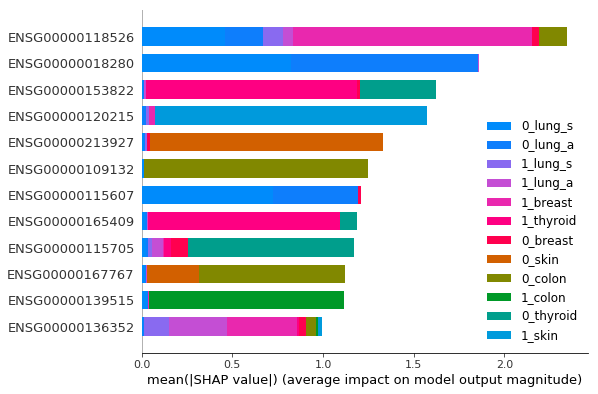

In [29]:
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X_test, tree_limit = -1)
shap.summary_plot(shap_values, X_test, plot_type="dot", class_names = loaded_model.classes_, max_display=12, layered_violin_max_num_bins=40)

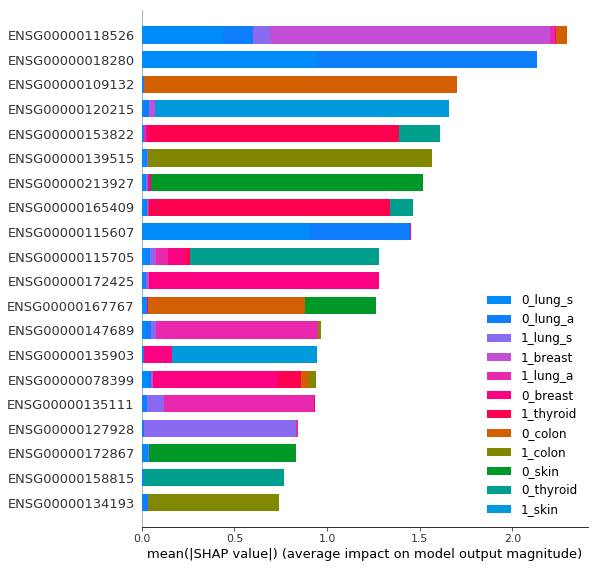

In [31]:
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X_test,approximate=True)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names = loaded_model.classes_)

In [ ]:
ENSG00000018280

In [43]:
loaded_model.classes_[7]

'1_colon'

In [58]:
X_interaction = X_train_all

shap_interaction_values = shap.TreeExplainer(loaded_model).shap_interaction_values(X_interaction)

shap.summary_plot(shap_interaction_values, X_interaction)

Exception: Model type not yet supported by TreeExplainer: <class 'str'>

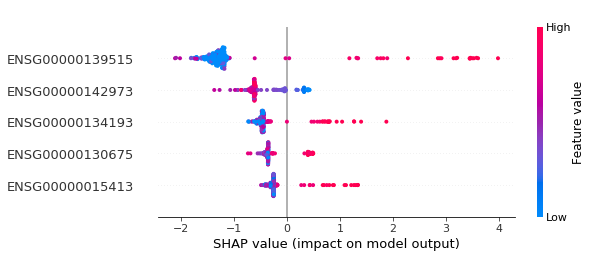

In [54]:
shap.summary_plot(shap_values[7], X_test_all, max_display = 5, plot_type = "dot")

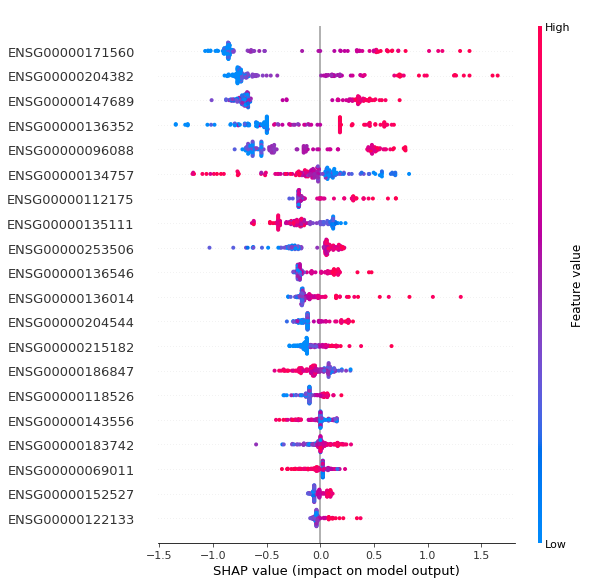

In [15]:
shap.summary_plot(shap_values[2], X_test)

In [ ]:
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X_train_all)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0])#, X_train_all)